# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [4]:
#Consolidated imports for running specific sections
import numpy as np
from glob import glob

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  

from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms

import os
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

use_cuda = torch.cuda.is_available()

In [5]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


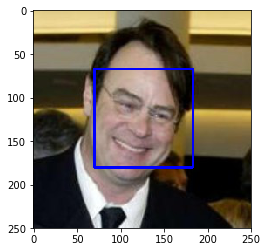

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
* Of the first 100 images in the `human_files` 98% have been detected as having a human face.
* Of the first 100 images in the `dog_files` 17% have been detected as having a human face.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
hf_count_in_hf = 0
hf_count_in_df = 0

for i in tqdm(range(100)):
    if face_detector(human_files_short[i]): hf_count_in_hf += 1
    if face_detector(dog_files_short[i]): hf_count_in_df += 1

print(f'Percentage in human_files: {hf_count_in_hf}')
print(f'Percentage in dog_files: {hf_count_in_df}')

100%|██████████| 100/100 [00:33<00:00,  3.01it/s]

Percentage in human_files: 98
Percentage in dog_files: 17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 57346995.29it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [6]:
print(use_cuda)

True


In [7]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    transform = transforms.Compose([transforms.Resize(size=224),
                                     transforms.CenterCrop(size=224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                    ])
    image = transform(image)
    return image

In [8]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = process_image(Image.open(img_path))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)
    if use_cuda:
        image = image.cuda()
    output = VGG16(image)

    _, pred = torch.max(output, 1)
    return pred # predicted class index

In [9]:
pred = VGG16_predict('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')
print(pred)

tensor([ 252], device='cuda:0')


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    dog_image_detected = False
    pred = VGG16_predict(img_path)
    pred = pred.item()
    #print('VGG16 pred class:', pred)
    if pred >= 151 and pred <= 268:
        dog_image_detected = True
    return dog_image_detected # true/false


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
* In the `human_files_short` 0% of the images have a detected dog.
* In the `dog_files_short` 100% of the images have a detected dog.

In [42]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
df_count_in_hf = 0
df_count_in_df = 0

for i in tqdm(range(100)):
    if dog_detector(human_files_short[i]): df_count_in_hf += 1
    if dog_detector(dog_files_short[i]): df_count_in_df += 1

print(f'Percentage in human_files: {df_count_in_hf}')
print(f'Percentage in dog_files: {df_count_in_df}')

100%|██████████| 100/100 [00:07<00:00, 14.77it/s]

Percentage in human_files: 0
Percentage in dog_files: 100


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

In [19]:
def process_image1(image, size):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    transform = transforms.Compose([transforms.Resize(size=size),
                                     transforms.CenterCrop(size=size),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                    ])
    image = transform(image)
    return image

In [37]:
def pre_trained_model_predict(img_path, model, size):
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = process_image1(Image.open(img_path), size)
    #image = np.expand_dims(image, 0)
    image = image.unsqueeze(0)
    #image = torch.from_numpy(image)
    if use_cuda:
        image = image.cuda()
    model.eval()
    output = model(image)

    _, pred = torch.max(output, 1)
    return pred # predicted class index

In [38]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector1(img_path, model, size):
    ## TODO: Complete the function.
    dog_image_detected = False
    pred = pre_trained_model_predict(img_path, model, size)
    pred = pred.item()
    if pred >= 151 and pred <= 268:
        dog_image_detected = True
    return dog_image_detected # true/false

In [16]:
model_inception = models.inception_v3(pretrained=True)
model_resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:01<00:00, 73008143.67it/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 19280617.46it/s]


In [45]:
if use_cuda:
    model_inception.cuda()
# performance with Inception V3
df_count_in_hf = 0
df_count_in_df = 0

dog_in_human_files = []
for i in tqdm(range(100)):
    if dog_detector1(human_files_short[i], model_inception, 299): 
        df_count_in_hf += 1
        dog_in_human_files.append(human_files_short[i])
    if dog_detector1(dog_files_short[i], model_inception, 299): df_count_in_df += 1

print(f'Percentage in human_files: {df_count_in_hf}')
print(f'Percentage in dog_files: {df_count_in_df}')

100%|██████████| 100/100 [00:08<00:00, 13.54it/s]

Percentage in human_files: 1
Percentage in dog_files: 100


In [6]:
def show_image(image_path):
    bgr_img = cv2.imread(image_path)
    # added the following step to remove the blue tinge - note it was added afterdisplaying the image below.
    cv_rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

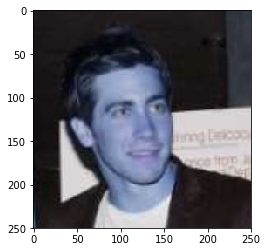

In [50]:
show_image(dog_in_human_files[0])

Inception V3 detected a dog in the above image which is obviously wrong!

In [40]:
if use_cuda:
    model_resnet.cuda()
# performance with Resnet 50
df_count_in_hf = 0
df_count_in_df = 0

for i in tqdm(range(100)):
    if dog_detector1(human_files_short[i], model_resnet, 224): df_count_in_hf += 1
    if dog_detector1(dog_files_short[i], model_resnet, 224): df_count_in_df += 1

print(f'Percentage in human_files: {df_count_in_hf}')
print(f'Percentage in dog_files: {df_count_in_df}')

100%|██████████| 100/100 [00:05<00:00, 17.66it/s]

Percentage in human_files: 0
Percentage in dog_files: 100


__Evaluate Other Pre-Trained Networks:__

* Inception V3 required image to be resized to 299 x 299.
* VGG16 & Resnet50 required image to be resized to 224 x 224.
* Resnet50 was the fastest with 5 seconds, followed by VGG16 with 7 seconds. Inception V3 was slightly slower than VGG16 - 8 seconds.
* Resnet50 & VGG16 did not detect any dog faces in the human files. Inception erroneously detected a dog in one of the human files. 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [51]:
import os
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

img_transforms = {
    # Training uses data augmentation
    'train' : transforms.Compose([transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
                                  transforms.RandomRotation(degrees=10),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ColorJitter(),
                                  transforms.CenterCrop(size=224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], 
                                                       [0.229, 0.224, 0.225])
                                ]),
    # Validation does not use data augmentation
    'valid' : transforms.Compose([transforms.Resize(size=224),
                                  transforms.CenterCrop(size=224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], 
                                                       [0.229, 0.224, 0.225])
                                ]),
    # Testing does not use data augmentation
    'test' : transforms.Compose([transforms.Resize(size=224),
                                 transforms.CenterCrop(size=224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])
                                ])}
    
batch_size = 64
train_dir = '/data/dog_images/train'
valid_dir = '/data/dog_images/valid'
test_dir = '/data/dog_images/test'

image_datasets = {
    'train' : ImageFolder(root=train_dir, transform=img_transforms['train']),
    'valid' : ImageFolder(root=valid_dir, transform=img_transforms['valid']),
    'test'  : ImageFolder(root=test_dir, transform=img_transforms['test'])
}

dataloaders = {
    'train' : DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'valid' : DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True),
    'test'  : DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True)
}

print('train size: {} valid size: {} test size: {}'.format(len(dataloaders['train'].dataset),
                                                            len(dataloaders['valid'].dataset),
                                                            len(dataloaders['test'].dataset)
                                                            ))
classes_size = len(image_datasets['train'].classes)
print('classes_size:', classes_size)

train size: 6680 valid size: 835 test size: 836
classes_size: 133


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

* I used the following transforms to resize & augment the training dataset. These transforms allows the CNN to be invariant to translation, viewpoint, scale/size or illumination.
    * RandomResizeCrop - Cropped the image to 224 x 224 which is the recommended minimum size for using the VGG16 model. Resized images randomly to 0.8% of original size & retained the aspect ratio.
    * RandomRotation - Rotate random images by 10%
    * RandomHorizontalFlip - Vertically flip the images randomly with a probability of 0.5
    * RandomColorJitter - Randomly change the brightness, contrast and saturation of an image.
* For validation & test sets, images were only resized.
* Finally, the images were normalized based on the mean & std specified in the PyTorch documentation [here](https://pytorch.org/docs/stable/torchvision/models.html)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [52]:
import torch.nn as nn
import torch.nn.functional as F


# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool4 = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(14 * 14 * 128, 2048)
        self.fc2 = nn.Linear(2048, 500)
        self.fc3 = nn.Linear(500, classes_size)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior

        x = self.pool4(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))

        x = x.view(-1, 14 * 14 * 128)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

My CNN has the following architecture,
* The input to the CNN is a 224 x 224 RGB image. 
* **Convolutional Layer 1**: The image is passed through a convolutional layer where I used filters of size 3 x 3 & padding of 1 to produce 32 feature maps with Relu activation.
* **Maxpooling layer**: The output of convolution layer 1 is fed to a maxpooling layer where I used a kernel size & stride of 4 to reduce the dimentions of the image to 56 x 56. This will reduce the number of parameters in the network & train faster.
* **Convolution Layer 2**: The image then passes through another convolution layer where I used filters of size 3 x 3 & padding of 1 to produce 64 feature maps with Relu activation.
* **Maxpooling layer**: The output of convolution layer 2 is fed to a maxpooling layer where I used a kernel size & stride of 2 to reduce the dimentions of the image to 28 x 28.
* **Convolution Layer 3**: The image then passes through another convolution layer where I used filters of size 3 x 3 again & padding of 1 to produce 128 feature maps with Relu activation.
* **Maxpooling layer**: The output of convolution layer 3 is fed to a maxpooling layer where I used a kernel size & stride of 2 to further reduce the dimentions of the image to 14 x 14.
* **Fully Connected Layers**: The output of the final maxpool layer is flattened into a vector & fed to a stack of 3 fully connected layers - the first has 2048 channels, 2nd 500 & the final layer has 133 cannels corresponding to the available classes in the dataset.
* Note I did not use ReLU activation for the fully connected layers. I tested with & without ReLU activation in the fully connected layers. The starting validation loss without ReLU was slightly lower (4.85) vs with ReLU (4.88). Hence I removed the ReLU activation. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [53]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

learning_rate = 0.01

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = learning_rate)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [67]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in tqdm(range(1, n_epochs+1)):
        #if epoch == 2: break
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            #if batch_idx == 1: break
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            #if batch_idx == 1: break
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)    
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                                                                                    epoch, 
                                                                                    train_loss,
                                                                                    valid_loss
                                                                                    ))
        
        ## TODO: save the model if validation loss has decreased

        if valid_loss <= valid_loss_min:
                print(f'Validation loss decreased from: {valid_loss_min:.6f} to: {valid_loss:.6f}')
                valid_loss_min = valid_loss
                torch.save(model.state_dict(), save_path)
                
    # return trained model
    return model

In [ ]:
# train the model
model_scratch = train(100, dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 1 	Training Loss: 4.866376 	Validation Loss: 4.851498
Validation loss decreased from: inf to: 4.851498


  1%|          | 1/100 [01:50<3:02:01, 110.32s/it]

Epoch: 2 	Training Loss: 4.838338 	Validation Loss: 4.810013
Validation loss decreased from: 4.851498 to: 4.810013


  2%|▏         | 2/100 [03:38<2:59:05, 109.65s/it]

Epoch: 3 	Training Loss: 4.767257 	Validation Loss: 4.722099
Validation loss decreased from: 4.810013 to: 4.722099


  3%|▎         | 3/100 [05:27<2:56:56, 109.45s/it]

Epoch: 4 	Training Loss: 4.670996 	Validation Loss: 4.645963
Validation loss decreased from: 4.722099 to: 4.645963


  4%|▍         | 4/100 [07:16<2:55:06, 109.44s/it]

Epoch: 5 	Training Loss: 4.589630 	Validation Loss: 4.601929
Validation loss decreased from: 4.645963 to: 4.601929


  5%|▌         | 5/100 [09:05<2:52:41, 109.07s/it]

Epoch: 6 	Training Loss: 4.535629 	Validation Loss: 4.575392
Validation loss decreased from: 4.601929 to: 4.575392


  6%|▌         | 6/100 [10:53<2:50:34, 108.88s/it]

Epoch: 7 	Training Loss: 4.494527 	Validation Loss: 4.525330
Validation loss decreased from: 4.575392 to: 4.525330


  7%|▋         | 7/100 [12:42<2:48:43, 108.86s/it]

Epoch: 8 	Training Loss: 4.430800 	Validation Loss: 4.484113
Validation loss decreased from: 4.525330 to: 4.484113


  8%|▊         | 8/100 [14:31<2:46:53, 108.84s/it]

Epoch: 9 	Training Loss: 4.354703 	Validation Loss: 4.419297
Validation loss decreased from: 4.484113 to: 4.419297


  9%|▉         | 9/100 [16:18<2:44:23, 108.39s/it]

Epoch: 10 	Training Loss: 4.275621 	Validation Loss: 4.339457
Validation loss decreased from: 4.419297 to: 4.339457


 10%|█         | 10/100 [18:03<2:40:54, 107.28s/it]

Epoch: 11 	Training Loss: 4.217918 	Validation Loss: 4.279149
Validation loss decreased from: 4.339457 to: 4.279149


 12%|█▏        | 12/100 [21:33<2:35:45, 106.20s/it]

Epoch: 12 	Training Loss: 4.151867 	Validation Loss: 4.314904
Epoch: 13 	Training Loss: 4.111491 	Validation Loss: 4.227270
Validation loss decreased from: 4.279149 to: 4.227270


 14%|█▍        | 14/100 [25:01<2:30:47, 105.21s/it]

Epoch: 14 	Training Loss: 4.069468 	Validation Loss: 4.233043


 15%|█▌        | 15/100 [26:46<2:28:37, 104.91s/it]

Epoch: 15 	Training Loss: 4.028560 	Validation Loss: 4.251582
Epoch: 16 	Training Loss: 3.986906 	Validation Loss: 4.197947
Validation loss decreased from: 4.227270 to: 4.197947


 16%|█▌        | 16/100 [28:31<2:27:08, 105.10s/it]

Epoch: 17 	Training Loss: 3.934794 	Validation Loss: 4.172157
Validation loss decreased from: 4.197947 to: 4.172157


 17%|█▋        | 17/100 [30:15<2:25:03, 104.87s/it]

Epoch: 18 	Training Loss: 3.895386 	Validation Loss: 4.153260
Validation loss decreased from: 4.172157 to: 4.153260


 19%|█▉        | 19/100 [33:42<2:20:20, 103.96s/it]

Epoch: 19 	Training Loss: 3.851237 	Validation Loss: 4.197756
Epoch: 20 	Training Loss: 3.797410 	Validation Loss: 4.110169
Validation loss decreased from: 4.153260 to: 4.110169


 20%|██        | 20/100 [35:25<2:18:26, 103.83s/it]

Epoch: 21 	Training Loss: 3.772803 	Validation Loss: 4.077520
Validation loss decreased from: 4.110169 to: 4.077520


 21%|██        | 21/100 [37:08<2:16:18, 103.53s/it]

Epoch: 22 	Training Loss: 3.721066 	Validation Loss: 4.061537
Validation loss decreased from: 4.077520 to: 4.061537


 23%|██▎       | 23/100 [40:37<2:13:38, 104.14s/it]

Epoch: 23 	Training Loss: 3.672170 	Validation Loss: 4.135724


 24%|██▍       | 24/100 [42:21<2:11:48, 104.06s/it]

Epoch: 24 	Training Loss: 3.636137 	Validation Loss: 4.087681


 25%|██▌       | 25/100 [44:03<2:09:27, 103.57s/it]

Epoch: 25 	Training Loss: 3.583515 	Validation Loss: 4.071082


 26%|██▌       | 26/100 [45:47<2:07:37, 103.48s/it]

Epoch: 26 	Training Loss: 3.533748 	Validation Loss: 4.147318


 27%|██▋       | 27/100 [47:32<2:06:37, 104.07s/it]

Epoch: 27 	Training Loss: 3.497831 	Validation Loss: 4.085878


 28%|██▊       | 28/100 [49:17<2:05:16, 104.39s/it]

Epoch: 28 	Training Loss: 3.452109 	Validation Loss: 4.256392


 29%|██▉       | 29/100 [51:00<2:03:04, 104.01s/it]

Epoch: 29 	Training Loss: 3.412611 	Validation Loss: 4.063428
Epoch: 30 	Training Loss: 3.349236 	Validation Loss: 3.979826
Validation loss decreased from: 4.061537 to: 3.979826


 31%|███       | 31/100 [54:31<2:00:17, 104.60s/it]

Epoch: 31 	Training Loss: 3.330500 	Validation Loss: 4.119312
Epoch: 32 	Training Loss: 3.240069 	Validation Loss: 3.972411
Validation loss decreased from: 3.979826 to: 3.972411


 33%|███▎      | 33/100 [58:01<1:56:57, 104.74s/it]

Epoch: 33 	Training Loss: 3.217751 	Validation Loss: 4.331366


 34%|███▍      | 34/100 [59:44<1:54:52, 104.43s/it]

Epoch: 34 	Training Loss: 3.168576 	Validation Loss: 4.116140


 35%|███▌      | 35/100 [1:01:29<1:53:14, 104.53s/it]

Epoch: 35 	Training Loss: 3.135078 	Validation Loss: 4.024065


 36%|███▌      | 36/100 [1:03:14<1:51:37, 104.65s/it]

Epoch: 36 	Training Loss: 3.082893 	Validation Loss: 4.024463


 37%|███▋      | 37/100 [1:04:57<1:49:26, 104.24s/it]

Epoch: 37 	Training Loss: 3.011088 	Validation Loss: 3.977742


 38%|███▊      | 38/100 [1:06:40<1:47:08, 103.68s/it]

Epoch: 38 	Training Loss: 2.957990 	Validation Loss: 4.067453


 39%|███▉      | 39/100 [1:08:21<1:44:44, 103.02s/it]

Epoch: 39 	Training Loss: 2.916949 	Validation Loss: 4.110358


 40%|████      | 40/100 [1:10:03<1:42:41, 102.69s/it]

Epoch: 40 	Training Loss: 2.858838 	Validation Loss: 4.436801


 41%|████      | 41/100 [1:11:47<1:41:24, 103.13s/it]

Epoch: 41 	Training Loss: 2.810236 	Validation Loss: 4.119773


 42%|████▏     | 42/100 [1:13:32<1:40:08, 103.60s/it]

Epoch: 42 	Training Loss: 2.756763 	Validation Loss: 4.191996


 43%|████▎     | 43/100 [1:15:17<1:38:41, 103.89s/it]

Epoch: 43 	Training Loss: 2.701475 	Validation Loss: 4.097260


 44%|████▍     | 44/100 [1:17:02<1:37:19, 104.28s/it]

Epoch: 44 	Training Loss: 2.661736 	Validation Loss: 4.158740


In [54]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [55]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [56]:
# call test function    
test(dataloaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.060738


Test Accuracy: 12% (103/836)


## Results with CNN created from Scratch

My Workspace lost connection while the train method was running the 45th epoch after training for more than 1 hr 17 mins. I had trained a couple other versions of the CNN before. 
The training loss was not reducing much. In fact it was lower in the 32nd epoch (3.97) vs the 44th epoch (4.15). So I tested with the best model that was saved & **got a 12% accuracy** which is higher than the requirement that it be more than 10%. 

To avoid using up more GPU time, I did not restart the training.   

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders

# I will be reusing the dataloaders created above

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [19]:
print(torch.__version__)

0.4.0


In [57]:
def build_classifier(n_inputs, hidden_dims, n_outputs, use_softmax=False):
    classifier = nn.Sequential()
    if hidden_dims == None:
        classifier.add_module('fc0', nn.Linear(n_inputs, n_outputs))
    else:
        layer_dims = zip(hidden_dims[:-1], hidden_dims[1:])
        classifier.add_module('fc0', nn.Linear(n_inputs, hidden_dims[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(p=0.5))
        if len(hidden_dims) > 1:
            for i, (h1, h2) in enumerate(layer_dims):
                classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
                classifier.add_module('relu'+str(i+1), nn.ReLU())
                classifier.add_module('drop'+str(i+1), nn.Dropout(p=0.5))
        classifier.add_module('output', nn.Linear(hidden_dims[-1], n_outputs))

    if use_softmax:
        classifier.add_module('softmax', nn.LogSoftmax(dim=1))
    return classifier

In [45]:
def train_with_early_stopping(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, max_epochs_stop=3, debug=False):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    best_epoch = 0
    epochs_no_improv = 0

    for epoch in tqdm(range(1, n_epochs+1)):
        if debug and epoch == 2: break
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if debug and batch_idx == 1: break
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if debug and batch_idx == 1: break
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)    
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                                                                                    epoch, 
                                                                                    train_loss,
                                                                                    valid_loss
                                                                                    ))
        
        ## TODO: save the model if validation loss has decreased

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased from: {valid_loss_min:.6f} to: {valid_loss:.6f}')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            epochs_no_improv = 0
            best_epoch = epoch
        else:
            epochs_no_improv += 1
            if epochs_no_improv >= max_epochs_stop:
                #Early Stopping
                print(f'Early Stopping. Epochs: {epoch} Best Epoch: {best_epoch} Valid Loss Min: {valid_loss_min}')
                return model
                
    # return trained model
    return model

In [58]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True) 

n_inputs = model_transfer.classifier[0].in_features
n_outputs = classes_size
hidden_dims = [1024, 500]
model_transfer.classifier = build_classifier(n_inputs, hidden_dims, n_outputs)
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False


if use_cuda:
    model_transfer = model_transfer.cuda()

In [59]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I decided to test a pre-trained VGG16 model available with PyTorch for implementing the Dog Breed classifier using Transfer Learning task. This model is trained on the ImageNet dataset which has 1000 classes whereas the dog images we will use have 133 classes. Hence, some changes will be required to the model to tailor it to predict dog breeds using the given dataset.

__Architecture__

The dataset for classifying the dog breeds is similar to the ImageNet dataset that was used to train the pre-trained VGG16 model. However, the give dataset is quite small. So we can retain all the convolutional layers along with their weights in the pre-trained VGG16 model. These layers have been trained on a similar but much larger dataset. Hence they will do a great job in recognizing dog shapes. However, since the no of classes in this task are different we will need to replace the fully connected layers in the VGG16 model.
I decided to use 3 fully connected layers with 1024, 500 & 133 channels in the 1st, 2nd & 3rd layer respectively. The final layer has 133 channels which correspond to the dog breed classes in the given dataset.
I will freeze the weights of the convolutional layers but train the fully connected layers so that they will have weights that are tailored to recognize the 133 classes in the dog images dataset. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [60]:
learning_rate = 0.001
'''
criterion_transfer = nn.NLLLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=learning_rate)
'''

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=learning_rate)


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
model_transfer = train_with_early_stopping(100, dataloaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')



  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 1 	Training Loss: 4.739202 	Validation Loss: 4.639164
Validation loss decreased from: inf to: 4.639164


  1%|          | 1/100 [03:16<5:24:43, 196.80s/it]

Epoch: 2 	Training Loss: 4.509329 	Validation Loss: 4.371098
Validation loss decreased from: 4.639164 to: 4.371098


  2%|▏         | 2/100 [06:20<5:14:57, 192.83s/it]

Epoch: 3 	Training Loss: 4.183560 	Validation Loss: 4.007895
Validation loss decreased from: 4.371098 to: 4.007895


  3%|▎         | 3/100 [09:23<5:07:06, 189.97s/it]

Epoch: 4 	Training Loss: 3.772107 	Validation Loss: 3.568384
Validation loss decreased from: 4.007895 to: 3.568384


  4%|▍         | 4/100 [12:26<5:00:20, 187.72s/it]

Epoch: 5 	Training Loss: 3.308222 	Validation Loss: 3.100785
Validation loss decreased from: 3.568384 to: 3.100785


  5%|▌         | 5/100 [15:29<4:55:09, 186.42s/it]

Epoch: 6 	Training Loss: 2.841542 	Validation Loss: 2.664394
Validation loss decreased from: 3.100785 to: 2.664394


  6%|▌         | 6/100 [18:33<4:51:05, 185.81s/it]

Epoch: 7 	Training Loss: 2.430673 	Validation Loss: 2.291432
Validation loss decreased from: 2.664394 to: 2.291432


  7%|▋         | 7/100 [21:37<4:46:56, 185.13s/it]

Epoch: 8 	Training Loss: 2.078337 	Validation Loss: 1.991908
Validation loss decreased from: 2.291432 to: 1.991908


  8%|▊         | 8/100 [24:40<4:43:06, 184.64s/it]

Epoch: 9 	Training Loss: 1.800548 	Validation Loss: 1.748847
Validation loss decreased from: 1.991908 to: 1.748847


  9%|▉         | 9/100 [27:42<4:38:51, 183.86s/it]

Epoch: 10 	Training Loss: 1.575094 	Validation Loss: 1.567127
Validation loss decreased from: 1.748847 to: 1.567127


 10%|█         | 10/100 [30:45<4:35:03, 183.38s/it]

Epoch: 11 	Training Loss: 1.395059 	Validation Loss: 1.414048
Validation loss decreased from: 1.567127 to: 1.414048


 11%|█         | 11/100 [33:48<4:31:59, 183.37s/it]

Epoch: 12 	Training Loss: 1.252049 	Validation Loss: 1.300561
Validation loss decreased from: 1.414048 to: 1.300561


 12%|█▏        | 12/100 [36:52<4:29:21, 183.65s/it]

Epoch: 13 	Training Loss: 1.134504 	Validation Loss: 1.203036
Validation loss decreased from: 1.300561 to: 1.203036


 13%|█▎        | 13/100 [39:57<4:26:33, 183.84s/it]

Epoch: 14 	Training Loss: 1.036915 	Validation Loss: 1.116417
Validation loss decreased from: 1.203036 to: 1.116417


 14%|█▍        | 14/100 [43:01<4:23:34, 183.89s/it]

Epoch: 15 	Training Loss: 0.955603 	Validation Loss: 1.055815
Validation loss decreased from: 1.116417 to: 1.055815


 15%|█▌        | 15/100 [46:04<4:20:19, 183.76s/it]

Epoch: 16 	Training Loss: 0.887198 	Validation Loss: 1.001258
Validation loss decreased from: 1.055815 to: 1.001258


 16%|█▌        | 16/100 [49:08<4:17:21, 183.82s/it]

Epoch: 17 	Training Loss: 0.836269 	Validation Loss: 0.942896
Validation loss decreased from: 1.001258 to: 0.942896


 17%|█▋        | 17/100 [52:12<4:14:16, 183.81s/it]

Epoch: 18 	Training Loss: 0.778449 	Validation Loss: 0.912036
Validation loss decreased from: 0.942896 to: 0.912036


 18%|█▊        | 18/100 [55:15<4:10:43, 183.45s/it]

Epoch: 19 	Training Loss: 0.734811 	Validation Loss: 0.870048
Validation loss decreased from: 0.912036 to: 0.870048


 19%|█▉        | 19/100 [58:17<4:07:19, 183.20s/it]

Epoch: 20 	Training Loss: 0.700221 	Validation Loss: 0.843914
Validation loss decreased from: 0.870048 to: 0.843914


 20%|██        | 20/100 [1:01:19<4:03:35, 182.70s/it]

Epoch: 21 	Training Loss: 0.663354 	Validation Loss: 0.808433
Validation loss decreased from: 0.843914 to: 0.808433


 21%|██        | 21/100 [1:04:21<4:00:23, 182.58s/it]

Epoch: 22 	Training Loss: 0.629944 	Validation Loss: 0.787293
Validation loss decreased from: 0.808433 to: 0.787293


 22%|██▏       | 22/100 [1:07:22<3:56:52, 182.21s/it]

Epoch: 23 	Training Loss: 0.610537 	Validation Loss: 0.757201
Validation loss decreased from: 0.787293 to: 0.757201


 23%|██▎       | 23/100 [1:10:25<3:54:02, 182.37s/it]

Epoch: 24 	Training Loss: 0.577977 	Validation Loss: 0.748596
Validation loss decreased from: 0.757201 to: 0.748596


 24%|██▍       | 24/100 [1:13:26<3:50:24, 181.91s/it]

Epoch: 25 	Training Loss: 0.553251 	Validation Loss: 0.725202
Validation loss decreased from: 0.748596 to: 0.725202


 25%|██▌       | 25/100 [1:16:30<3:48:01, 182.43s/it]

Epoch: 26 	Training Loss: 0.533297 	Validation Loss: 0.709057
Validation loss decreased from: 0.725202 to: 0.709057


 26%|██▌       | 26/100 [1:19:32<3:45:11, 182.59s/it]

Epoch: 27 	Training Loss: 0.509324 	Validation Loss: 0.691970
Validation loss decreased from: 0.709057 to: 0.691970


 27%|██▋       | 27/100 [1:22:35<3:41:59, 182.46s/it]

Epoch: 28 	Training Loss: 0.496595 	Validation Loss: 0.677768
Validation loss decreased from: 0.691970 to: 0.677768


 28%|██▊       | 28/100 [1:25:35<3:38:21, 181.97s/it]

Epoch: 29 	Training Loss: 0.473532 	Validation Loss: 0.669019
Validation loss decreased from: 0.677768 to: 0.669019


 29%|██▉       | 29/100 [1:28:34<3:34:13, 181.03s/it]

Epoch: 30 	Training Loss: 0.454830 	Validation Loss: 0.662416
Validation loss decreased from: 0.669019 to: 0.662416


 30%|███       | 30/100 [1:31:37<3:31:41, 181.45s/it]

Epoch: 31 	Training Loss: 0.448975 	Validation Loss: 0.638430
Validation loss decreased from: 0.662416 to: 0.638430


 31%|███       | 31/100 [1:34:40<3:29:17, 182.00s/it]

Epoch: 32 	Training Loss: 0.433826 	Validation Loss: 0.629100
Validation loss decreased from: 0.638430 to: 0.629100


 32%|███▏      | 32/100 [1:37:43<3:26:43, 182.41s/it]

Epoch: 33 	Training Loss: 0.419233 	Validation Loss: 0.621734
Validation loss decreased from: 0.629100 to: 0.621734


 33%|███▎      | 33/100 [1:40:46<3:23:45, 182.46s/it]

Epoch: 34 	Training Loss: 0.407106 	Validation Loss: 0.613024
Validation loss decreased from: 0.621734 to: 0.613024


 34%|███▍      | 34/100 [1:43:49<3:21:01, 182.76s/it]

Epoch: 35 	Training Loss: 0.396162 	Validation Loss: 0.603794
Validation loss decreased from: 0.613024 to: 0.603794


 36%|███▌      | 36/100 [1:49:55<3:14:51, 182.68s/it]

Epoch: 36 	Training Loss: 0.386388 	Validation Loss: 0.607681
Epoch: 37 	Training Loss: 0.373586 	Validation Loss: 0.596237
Validation loss decreased from: 0.603794 to: 0.596237


 37%|███▋      | 37/100 [1:52:58<3:11:56, 182.80s/it]

Epoch: 38 	Training Loss: 0.362259 	Validation Loss: 0.588489
Validation loss decreased from: 0.596237 to: 0.588489


 38%|███▊      | 38/100 [1:55:58<3:08:15, 182.19s/it]

In [61]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [62]:
test(dataloaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.566720


Test Accuracy: 83% (699/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [63]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    image = process_image(Image.open(img_path))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)
    if use_cuda:
        image = image.cuda()
    output = model_transfer(image)
    
    _, pred = torch.max(output, 1)
    pred = np.squeeze(pred.cpu().numpy())
    pred_breed = class_names[pred]
    
    return pred_breed

In [64]:
pred_breed = predict_breed_transfer('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')
print(pred_breed)

Affenpinscher


Image Path: /data/dog_images/train/037.Brittany/Brittany_02647.jpg
Predicted Breed: Brittany


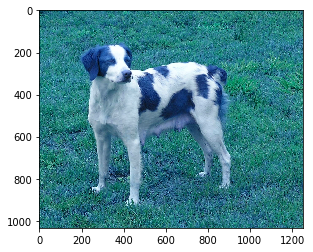

Image Path: /data/dog_images/valid/020.Belgian_malinois/Belgian_malinois_01448.jpg
Predicted Breed: German shepherd dog


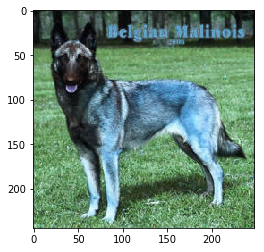

Image Path: /data/dog_images/valid/125.Portuguese_water_dog/Portuguese_water_dog_07996.jpg
Predicted Breed: Portuguese water dog


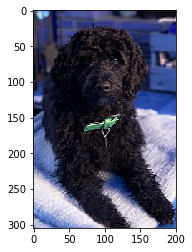

Image Path: /data/dog_images/train/015.Basset_hound/Basset_hound_01058.jpg
Predicted Breed: Basset hound


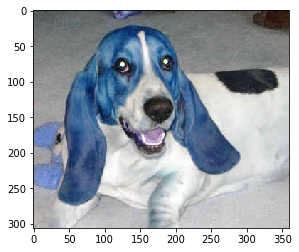

Image Path: /data/dog_images/train/091.Japanese_chin/Japanese_chin_06195.jpg
Predicted Breed: Japanese chin


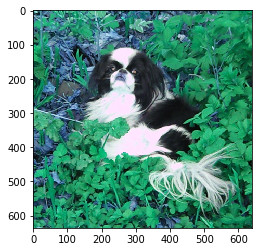

In [65]:
import random

test_image_paths = random.choices(dog_files, k=5)
for image_path in test_image_paths:
    print('Image Path:', image_path)
    pred_breed = predict_breed_transfer(image_path)
    print('Predicted Breed:', pred_breed)
    show_image(image_path)
       

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [73]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    print('Image Path:', img_path)
    pred_breed = predict_breed_transfer(img_path)
    show_image(img_path)
    if dog_detector(img_path):
        print('Dog detected! Predicted Breed:', pred_breed)        
    elif face_detector(img_path):
        print('You look like a ', pred_breed)
    else:
        print('Error! You seem to be from another planet!')
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__

The pre-trained VGG16 model with a new set of fully connected layers trained on the dog images provided for this project acheieved a 83% accuracy on the test dataset (the workspace lost connection after almost 2 hours of running 38 epochs). I tested the final model on 6 additional images - 3 dog & 3 human & it did a great job predicting 2 breeds correctly & it came very close to the 3rd breed. The results were better than I expected! The 3rd prediction is prettly close & as pointed out previously, it would be very hard even for a human to differentiate between the predcited & actual breed.

__Suggestions for Improvements__

* The dataset supplied has 8351 images only. One method to improve the accuracy would be to use a larger dataset. This will probably be the biggest factor in improving the accuracy.
* I used a learning rate of 0.01. I did try to use a smaller value but that reduced the speed of training a lot. One method to improve the accuracy could be to use a scalable training setup with smaller learning rate.
* Change architecture of the fully connected layers. 
* Training with other pre-trained models would be another approach to improve accuracy. 

Image Path: /data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg


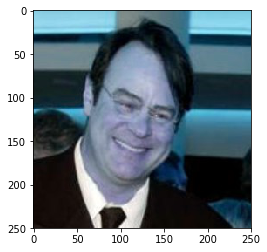

You look like a  Chinese crested
Image Path: /data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg


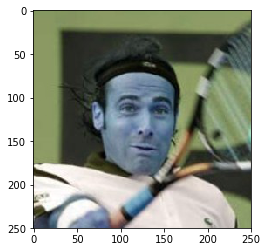

You look like a  Chinese crested
Image Path: /data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg


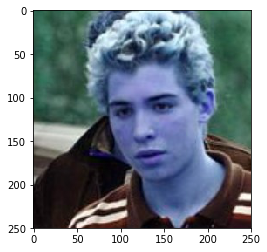

You look like a  Poodle
Image Path: /data/dog_images/train/103.Mastiff/Mastiff_06833.jpg


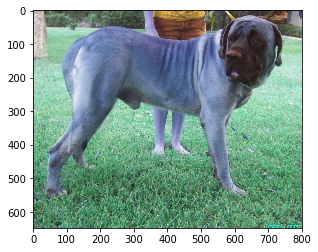

Dog detected! Predicted Breed: Bullmastiff
Image Path: /data/dog_images/train/103.Mastiff/Mastiff_06826.jpg


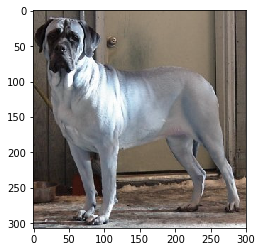

Dog detected! Predicted Breed: Mastiff
Image Path: /data/dog_images/train/103.Mastiff/Mastiff_06871.jpg


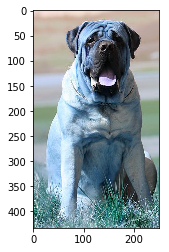

Dog detected! Predicted Breed: Mastiff


In [74]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

In [71]:
test_images = np.array(glob("test_images/*"))
len(test_images)

6

Image Path: test_images/poodle.jpg


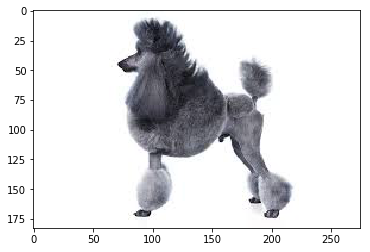

Dog detected! Predicted Breed: Poodle
Image Path: test_images/nilesh-big-table.jpg


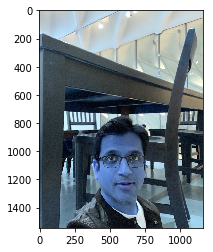

You look like a  Poodle
Image Path: test_images/german-shepherd.jpg


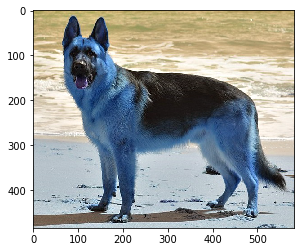

Dog detected! Predicted Breed: German shepherd dog
Image Path: test_images/elon-musk.jpg


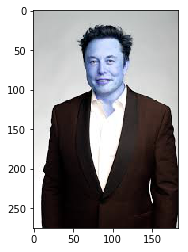

You look like a  Smooth fox terrier
Image Path: test_images/siberian-husky.png


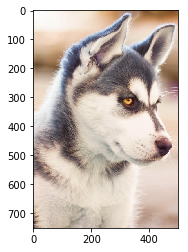

Dog detected! Predicted Breed: Alaskan malamute
Image Path: test_images/kim-k.jpg


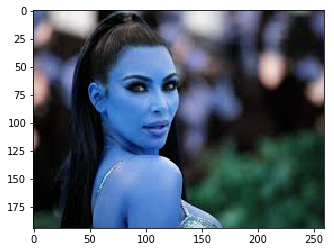

You look like a  Chinese crested


In [75]:
for file in test_images:
    run_app(file)